# Лабораторная 5. Решающие деревья. Случайный лес.

In [ ]:
# используемые библиотеки
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import pandas as pd

## 1. Метрики качества классификации

### 1.1 Accuracy(точность)

В задаче классификации самой простой является метрика ***accuracy***, численно равная числу правильно предсказанных объектов к общему числу предсказаний. Однако у такой метрики есть один существенный недостаток.

Рассмотрим простой пример. Пусть у нас есть тестовая выборка, содержащая 10000 объектов класса A и 100 объектов класса B. Пусть наш классификатор ***всегда*** предсказывает класс A. Тогда точность такого классификатора будет равна $\frac{10000}{10000 + 100} = 0.99$.

Кажется, что это много, но задумайтесь, высокая ли предсказательная способность у нашего алгоритма. Ведь мы совсем не предсказываем B класс.

Метрика accuracy больше подходит в случае сбалансированных классов (классов, где доля объектов каждого класса примерно одинакова). В случае несбалансированных классов могут быть использованы другие метрики, такие как ***precision*** и ***recall***.

### 1.2 Precision и Recall

Пусть существуют два класса - положительный и отрицательный.

***Recall (полнота)***:
$$Recall = \frac{TP}{TP + FN}$$

***Precision (точность)***:
$$Precision = \frac{TP}{TP + FP}$$


Где:

$TP$ - количество верно предсказанных положительных объектов (True Positives)

$TN$ - количество верно предсказанных отрицательных объектов (True Negatives)

$FP$ - количество ложно предсказанных положительных объектов (False Positives)

$FN$- количество ложно предсказанных отрицательных объектов (False Negatives)

***Recall*** показывает, насколько хорошо модель обнаруживает положительные объектов из всего множества положительных объектов. Высокое значение recall указывает на то, что модель не пропускает много положительных объектов.

***Precision*** показывает, какую долю из всех объектов, которые модель предсказала как положительные, были действительно положительными. Высокое значение precision означает, что большинство предсказанных моделью положительных объектов действительно являются положительными.

Recall и precision следует рассматривать вместе в контексте задачи классификации, так как они оценивают разные качества работы модели, и иногда может потребоваться балансировка между ними в зависимости от конкретных требований задачи.

### 1.3 F1-score

***F1-score*** - это метрика, которая объединяет в себе precision (точность) и recall (полноту) в единственное численное значение. Она является гармоническим средним между precision и recall и позволяет учесть обе метрики одновременно.

F1-score вычисляется по следующей формуле:
$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$
Эта метрика достигает своего максимального значения при точности и полноте, близких к 1. F1-score позволяет учесть баланс между полнотой и точностью модели, так как при низком значении хотя бы одной метрики, значение F1 будеть невелико.

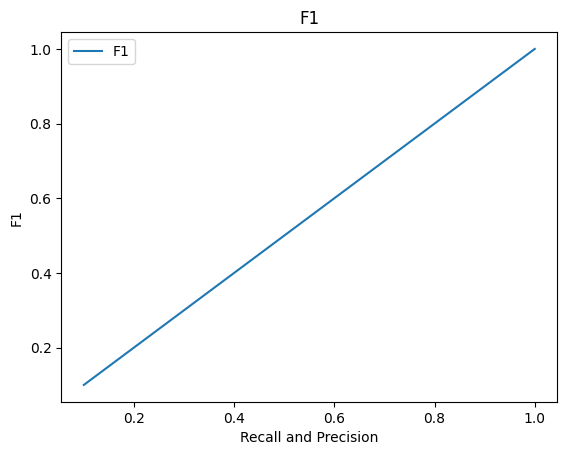

In [ ]:
# значения recall, precision и F1
r = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
pr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
f1 = []
for i in range(len(r)):
    f1.append(2*r[i]*pr[i]/(r[i] + pr[i]))

# построение графика
plt.plot(r, f1, label='F1')
plt.xlabel('Recall and Precision')
plt.ylabel('F1')
plt.title('F1')
plt.legend()
plt.show()

***Взвешенная F1-score*** - это метрика, которая учитывает F1-score для каждого класса, взвешивая их по количеству экземпляров каждого класса. Она полезна при несбалансированных данных, так как она принимает во внимание как точность, так и полноту для каждого класса.

Формула для взвешенной F1-score:
$$F1_{weighted} = \frac{\sum_{i=1}^{N} w_i \cdot F1_i}{\sum_{i=1}^{N} w_i}$$

где:
- $N$ - количество классов
- $F1_i$ - F1-score для класса $i$
- $w_i$ - вес класса $i$ (число объектов класса, делённое на общее число объектов в выборке.   

### 1.4 ROC-AUC

$$ FPR = \frac{FP}{FP + TN} $$

$$ TPR = \frac{TP}{TP + FN} $$

***ROC-кривая*** - это график, который отображает предсказательную способность модели при различных порогах классификации. Ось X представляет долю ложно положительных классификаций (FPR), а ось Y представляет долю верно положительных классификаций (TPR), которая также называется полнотой или recall.

***AUC (Area Under the Curve)*** ROC-кривой - это численное значение, равное площади под ROC-кривой.

- AUC ROC близок к 1, если модель хорошо разделяет классы
- AUC ROC близок к 0.5, если модель случайно классифицирует классы

ROC-AUC: 0.9600


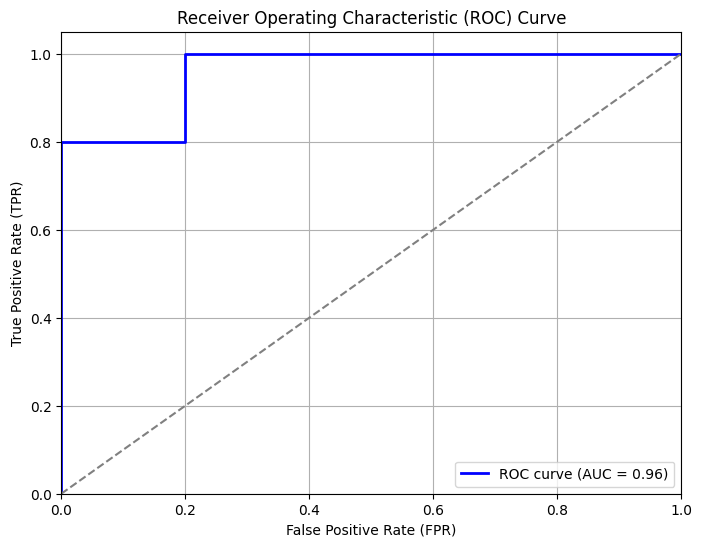

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Данные
y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 0]
y_prob = [0.9, 0.3, 0.8, 0.4, 0.2, 0.7, 0.6, 0.1, 0.95, 0.2]

# Вычисление значений для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Расчет ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайной модели
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 1.5 Метрики классификации в sklearn

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    confusion_matrix,
    matthews_corrcoef,
)

# Данные
y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_pred = [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0]
y_prob = [0.9, 0.2, 0.8, 0.4, 0.2, 0.7, 0.6, 0.1, 0.95, 0.2, 0.55, 0.1, 0.3, 0.2, 0.1]

# 1. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

# 3. Recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

# 4. F1-Score
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

# 5. ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8000
Precision: 0.6667
Recall: 0.8000
F1-Score: 0.7273
ROC-AUC: 0.9600


### Задача1(1 балл)

1. Дан медицинский датасет, где мы классифицируем пациентов на наличие болезни(лечение которой крайне необходимо). Какая метрика (recall, precision, accuracy) лучше всего подходит для данного датасета? Почему?

2. Дан датасет сообщений, где мы хотим понять является сообщение спамом или нет. Какая метрика (recall, precision, accuracy) лучше всего подходит для данного датасета? Почему?

3. Дан датасет, где мы классифицируем рукописные цифры(на 10 классов). Какая метрика (recall, precision, accuracy) лучше всего подходит для данного датасета? Почему?

### Задача 2(2 балла)

***Датасет MNIST*** (Modified National Institute of Standards and Technology database) — это очень популярный датасет, который состоит из изображений рукописных цифр от 0 до 9. Всего в датасете 70,000 изображений.

Каждое изображение представляет собой черно-белую картинку размером 28x28 пикселей. Каждый пиксель представлен числом от 0 до 255, где 0 обозначает черный цвет, а 255 - белый.

1. Обучите модель k-nn на X_train.
2. Расчитайте accuracy, recall, precision(значение каждой метрики должно превыщать 0.97) на X_test.
3. Рассчитайте f1.
4. Ответьте, почему значения всех трёх метрикa(accuracy, recall, precision) очень похожи.

In [ ]:
# Загрузка датасета MNIST
mnist = fetch_openml('mnist_784')

In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, random_state=42)

In [ ]:
# Один объект выборки это просто массив чисел от 0 до 255
X_train.iloc[0]

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 42878, Length: 784, dtype: int64

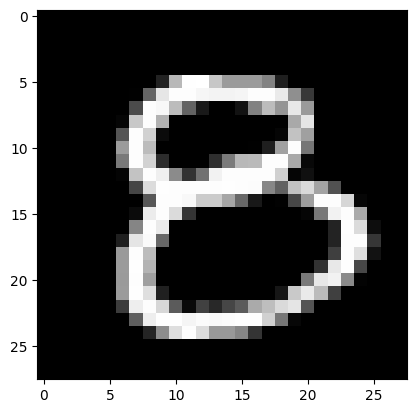

In [ ]:
# Объект - это цифра, которая представлена в виде одномерного массива
plt.imshow(np.array(X_train.iloc[0]).reshape(28,28), cmap='gray')
plt.show()

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y = knn.predict(X_test)

In [ ]:
# Инициализация и обучение модели k-NN
# ВАШ КОД ЗДЕСЬ

# Предсказание меток классов на тестовом наборе
# ВАШ КОД ЗДЕСЬ

# Вычисление и вывод метрик accuracy, recall и precision
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred, average="macro")}')
print(f'Precision: {precision_score(y_test, y_pred, average="macro")}')

# Вычисление F1
# ВАШ КОД ЗДЕСЬ

## 2. Метрики качества регрессии

### **2.1. Mean Absolute Error (MAE)**
- **Определение:** Средняя абсолютная ошибка — это среднее значение модулей разностей между истинными и предсказанными значениями.
- **Формула:**
  $$
  \text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
  $$
  где:
  - $y_i$ — истинное значение,
  - $\hat{y}_i$ — предсказанное значение,
  - $N$ — количество примеров.
- **Преимущества:**
  - Интуитивно понятна (измеряется в тех же единицах, что и целевой признак).
  - Устойчива к выбросам, так как использует модуль разности.
- **Недостатки:**
  - Не штрафует сильные ошибки так сильно, как другие метрики.

---

### **2.2. Mean Squared Error (MSE)**
- **Определение:** Средняя квадратическая ошибка — это среднее значение квадратов разностей между истинными и предсказанными значениями.
- **Формула:**
  $$
  \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
  $$
- **Преимущества:**
  - Чувствительна к большим ошибкам (квадратичная функция усиливает влияние выбросов).
  - Широко используется в задачах оптимизации (например, градиентный спуск).
- **Недостатки:**
  - Измеряется в квадратах единиц целевого признака, что делает её менее интуитивной.

---

### **2.3. Root Mean Squared Error (RMSE)**
- **Определение:** Корень из средней квадратической ошибки. Это аналог MSE, но результат измеряется в тех же единицах, что и целевой признак.
- **Формула:**
  $$
  \text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
  $$
- **Преимущества:**
  - Более интерпретируема, чем MSE, так как измеряется в исходных единицах.
  - Сохраняет чувствительность к выбросам.
- **Недостатки:**
  - Как и MSE, больше штрафует большие ошибки.

---

### **2.4. Mean Absolute Percentage Error (MAPE)**
- **Определение:** Средняя абсолютная процентная ошибка — это среднее значение относительных ошибок в процентах.
- **Формула:**
  $$
  \text{MAPE} = \frac{1}{N} \sum_{i=1}^{N} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \cdot 100\%
  $$
- **Преимущества:**
  - Позволяет оценить ошибку в относительных единицах (процентах), что полезно для сравнения моделей на разных масштабах данных.
- **Недостатки:**
  - Неопределена, если истинное значение равно нулю ($y_i = 0$).
  - Может быть нестабильной при малых значениях $y_i$.

---

### **2.5. R-squared (R² или Коэффициент детерминации)**
- **Определение:** Мера того, насколько хорошо модель объясняет изменчивость целевого признака. Значение лежит в диапазоне от $-\infty$ до 1, где 1 означает идеальную модель, а 0 — модель, которая не лучше константного предсказания.
- **Формула:**
  $$
  R^2 = 1 - \frac{\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y})^2}
  $$
  где:
  - $\bar{y}$ — среднее значение целевого признака.
- **Преимущества:**
  - Позволяет оценить, насколько хорошо модель работает по сравнению с простой константной моделью.
  - Интерпретируется как доля объясненной дисперсии.
- **Недостатки:**
  - Может быть обманчива, если данные содержат много шума или модель переобучена.

### 1.6 Метрики регрессии в sklearn

In [ ]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    mean_squared_log_error,
    median_absolute_error,
    max_error
)

# Данные
y_true = [3.0, -0.5, 2.0, 7.0]
y_pred = [2.5, 0.0, 2.0, 8.0]

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 3. Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 4. R-squared (R²)
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R²): {r2:.4f}")

# 5. Mean Absolute Percentage Error (MAPE)
# Примечание: MAPE не определена, если есть нулевые или отрицательные значения в y_true
try:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.4f}%")
except ValueError as e:
    print(f"Mean Absolute Percentage Error (MAPE): Неопределена ({e})")

Mean Absolute Error (MAE): 0.5000
Mean Squared Error (MSE): 0.3750
Root Mean Squared Error (RMSE): 0.6124
R-squared (R²): 0.9486
Mean Absolute Percentage Error (MAPE): 32.7381%


/home/ivanmipt/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 3. Решающие дерево

***Перед выполнением данного блока рекомендуется ознакомиться с лекцией 2.***

***Энтропийный критерий*** (или критерий информационной энтропии) является одним из критериев ветвления, используемых при построении решающих деревьев в задачах классификации. Он основан на понятии энтропии и измеряет степень хаоса или неопределенности в данных.

Информационная энтропия для узла $v$ с множеством объектов $X$ определяется следующим образом:
$$H(X) = -\sum_{i=1}^{C} p(i|v) \log_2 p(i|v)$$
где:
- $C$ - количество классов
- $p(i|v)$ - доля объектов класса $i$ в узле $v$

Энтропия достигает максимума при равном распределении объектов по классам и минимума, когда все объекты относятся к одному классу.

В задаче классификации, ***критерий Джини*** - это один из способов измерения информативности разбиения при построении решающих деревьев. Иногда его называют "Индексом Джини" или "Индексом неопределенности Джини". Критерий Джини используется для оценки того, насколько хорошо разбиение узла уменьшает неопределенность (или "чистоту") данных.

Индекс Джини для узла с множеством объектов $X$ различными классами определяется следующим образом:

$$ {Gini}(X) = \sum_{i=1}^{C} (1-p_i)p_i $$

где:
- $p_i$ - доля объектов класса $i$ в узле

Критерий Джини принимает значение от 0 до 1. Чем ближе значение к 0, тем чище (более однородные по классам) узел, а чем ближе к 1, тем более неопределенными (менее однородными) являются данные в узле.

### Задача 3(1 балл)

1. Реализуйте функцию, вычисляющую энтропию для данного узла (принимает на вход множество X).
2. Реализуйте функцию, вычисляющую индекс Джини для данного узла (принимает на вход множество X).

### 3.1 Решающее дерево в scikit-learn

***Гиперпараметры:***

***criterion*** = 'gini' - функция для измерения качества разбиения. Поддерживаются критерии 'gini' для неодородности Джини и 'entropy' для прироста информации

***splitter***='best' - стратегия, используемая для выбора разбиения в каждом узле. Поддерживаются стратегии 'best' для выбора лучшего разбиения и 'random' для выбора лучшего рандомного разбиения

***max_depth***=None - максимальная глубина дерева. Если None, то дерево строится до тех пор, пока в каждом листе не будет только один класс или пока каждый лист не будет содержать количество экземпляров, равное min_samples_split.

***max_leaf_nodes***=None - максимальное количество листьев. Дерево строится исходя из ограничения на максимальное количество листьев. Остаются только те листья, которые максимально уменьшают неоднородность.

***min_impurity_decrease***=0.0 - минимальное уменьшение неоднородности. Узел расщепляется, если неоднородность уменьшается на число больше или равное min_impurity_decrease.

Это лишь самые популярные гиперпараметры. На самом деле их намного больше.

In [ ]:
# Загрузка датасета о раке груди
data = load_breast_cancer()
X, y = data.data, data.target

# Разделение датасета на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели решающего дерева
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Предсказание
y_pred = clf.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9298245614035088


### Задача 4(2 балла)
1. Постройте график точности от глубины дерева.
2. Найдите оптимальные гиперпараметры среди: criterion, max_depth.
3. Постройте графики зависимости точности от max_depth для двух разных критериев.

## 4. Случайный лес

***Случайный лес*** - это ансамблевая модель машинного обучения, которая состоит из множества решающих деревьев. Основная идея случайного леса заключается в том, что каждое дерево строится независимо друг от друга, используя случайные подвыборки данных и случайные подмножества признаков.

Основные этапы построения:

***Бутстрэп выборка***: Для построения каждого дерева случайного леса используется бутстрэп выборка, то есть случайная выборка из исходного набора данных. Это позволяет создавать различные подвыборки для каждого дерева.

***Случайный выбор признаков***: При разбиении узлов в каждом дереве случайного леса, выбирается случайное подмножество признаков. Это позволяет деревьям быть разнообразными и уменьшает корреляцию между ними.

***Итоговое предсказание***: При получении новых данных, случайный лес объединяет предсказание каждого дерева и использует их для получения окончательного предсказания. Обычно это осуществляется путем усреднения предсказаний для задачи регрессии или голосования большинства для задачи классификации.

Преимущества случайного леса включают в себя хорошую способность к обобщению, устойчивость к переобучению, способность работы с большим количеством признаков и автоматическое устранение шума. Случайный лес часто используется в практике машинного обучения для задач классификации и регрессии благодаря своей высокой производительности и эффективности.

### Задача 5(2 балла)

Решите предыдущую задачу, используя случайный лес.